In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

# Set the style
sns.set_theme(style="whitegrid")

# Set general plot parameters for Overleaf (1-column A4)
plt.rcParams.update(
    {
        "figure.figsize": (3.3, 2.5),  # inches, ~1-column width
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 14,
        "pdf.fonttype": 42,  # vector fonts
        "ps.fonttype": 42,
    }
)

PATH = "./outputs"
SUBFOLDERS = ["wellbeing", "achievement", "delinquency", "ptsd"]
LABELS = [
    "gpt-5-mini",
    "Phi-4",
    "Qwen-3-30B",
    "Llama-3.3-70B",
    "Magistral-Small",
    "Qwen-Next-80B",
]
GROLTS_LABELS_OLD = [
    "1",
    "2",
    "3a",
    "3b",
    "3c",
    "4",
    "5",
    "6a",
    "6b",
    "7",
    "8",
    "9",
    "10",
    "11",
    "12",
    "13",
    "14a",
    "14b",
    "14c",
    "15",
    "16",
]
GROLTS_LABELS_NEW = [
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
]
ID_MAP = {
    0: 0,
    1: 1,
    2: 4,
    3: 5,
    4: 6,
    5: 7,
    6: 9,
    7: 10,
    8: 11,
    9: 12,
    10: 13,
    11: 13,
    12: 14,
    13: 14,
    14: 15,
    15: 16,
    16: 18,
    17: 19,
    18: 20,
}

In [2]:
def load_llm_scores(df_labels, files):
    """
    Aggregate total/average scores per paper from each prediction file
    and compare them with the true scores from df_labels.
    """

    scores_data = {}

    for i, f in enumerate(files):
        df = pd.read_csv(f"{PATH}/{f}")
        # Sum or average the scores per paper (adjust depending on your scale)
        paper_scores = df.groupby("paper_id")["answer"].sum()
        scores_data[LABELS[i]] = paper_scores

    # Combine all models' paper-level scores
    scores_df = pd.DataFrame(scores_data).sort_index()

    # Compute the true total scores per paper
    true_scores = df_labels.groupby("paper_id")["answer"].sum()
    scores_df["true_score"] = true_scores
    scores_df = scores_df.reset_index()

    # Compute rank order per column
    rank_df = scores_df.rank(ascending=False, method="dense")
    rank_df = rank_df.reset_index()

    # Compare rank differences between each model and the true labels
    rank_diff = rank_df.subtract(rank_df["true_score"], axis=0)
    rank_diff = rank_diff.reset_index()

    return scores_df, rank_df, rank_diff


def plot_rank_correlation(rank_dfs, labels):
    fig, axes = plt.subplots(1, len(rank_dfs), figsize=(6 * len(rank_dfs), 5))
    if len(rank_dfs) == 1:
        axes = [axes]

    for i, (df, ax) in enumerate(zip(rank_dfs, axes)):
        # Select only score columns (exclude 'paper_id' or other metadata)
        score_cols = [
            c for c in df.columns if c not in ["paper_id", "true_score", "index"]
        ]
        score_cols.append("true_score")  # include human score for correlation

        corr = df[score_cols].corr(method="spearman")
        sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
        ax.set_title(f"Rank Correlation - {labels[i]}")

    plt.tight_layout()
    plt.show()


def plot_scores_by_paper(scores_df, case_label):
    """
    scores_df: DataFrame with columns ['paper_id', 'true_score', model1, model2, ...]
    """
    # Sort papers by true_score
    scores_df = scores_df.sort_values("true_score").reset_index(drop=True)
    x = range(len(scores_df))  # numeric positions for plotting

    plt.figure(figsize=(12, 5))

    # Plot true score as a line
    plt.plot(
        x, scores_df["true_score"], label="Human (True)", color="black", linewidth=2
    )

    # Plot each LLM as scatter points
    llm_cols = [
        c for c in scores_df.columns if c not in ["paper_id", "true_score", "index"]
    ]
    colors = sns.color_palette("tab10", n_colors=len(llm_cols))

    for col, color in zip(llm_cols, colors):
        plt.scatter(x, scores_df[col], label=col, color=color, s=50, alpha=0.7)

    # Set paper_ids as x-tick labels
    plt.xticks(x, scores_df["paper_id"].astype(int), rotation=0)

    plt.xlabel("Paper ID (sorted by human score)")
    plt.ylabel("Score")
    plt.title(f"Scores per Paper - {case_label}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def best_matching_llm_rank(scores_df):
    llm_cols = [
        c for c in scores_df.columns if c not in ["paper_id", "true_score", "index"]
    ]
    correlations = {}

    for col in llm_cols:
        corr, _ = spearmanr(scores_df["true_score"], scores_df[col])
        correlations[col] = corr

    best_llm = max(correlations, key=correlations.get)
    return best_llm, correlations


def best_matching_llm_mae(scores_df):
    llm_cols = [
        c for c in scores_df.columns if c not in ["paper_id", "true_score", "index"]
    ]
    maes = {}

    for col in llm_cols:
        maes[col] = (scores_df[col] - scores_df["true_score"]).abs().mean()

    best_llm = min(maes, key=maes.get)
    return best_llm, maes


def best_matching_llm_rmse(scores_df):
    llm_cols = [
        c for c in scores_df.columns if c not in ["paper_id", "true_score", "index"]
    ]
    rmses = {}

    for col in llm_cols:
        rmses[col] = np.sqrt(((scores_df[col] - scores_df["true_score"]) ** 2).mean())

    best_llm = min(rmses, key=rmses.get)
    return best_llm, rmses


def ranking_agreement(rank_df, epsilon=2):
    """
    rank_df: DataFrame with columns ['paper_id', 'true_score', model1, model2, ...]
             ranks are precomputed (1 = highest)
    epsilon: allowed rank difference
    Returns: series with fraction of papers within epsilon for each model
    """
    llm_cols = [
        c for c in rank_df.columns if c not in ["paper_id", "true_score", "index"]
    ]
    true_ranks = rank_df["true_score"]
    agreement = {}

    for col in llm_cols:
        diffs = (rank_df[col] - true_ranks).abs()
        agreement[col] = (diffs <= epsilon).mean()  # fraction of papers within epsilon

    return pd.Series(agreement)


def plot_ranking_agreement(all_case_agreements, case_labels):
    """
    all_case_agreements: list of Series from ranking_agreement(), one per case study
    case_labels: list of case study names
    """
    df_plot = pd.DataFrame(all_case_agreements, index=case_labels)
    df_plot.T.plot(kind="bar", figsize=(10, 6))
    plt.ylabel("Fraction of papers within epsilon")
    plt.title("LLM Ranking Agreement with Human (epsilon method)")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title="Case Study")
    plt.tight_layout()
    plt.show()


def plot_ranking_scatter_with_epsilon(rank_df, case_label, epsilon=2):
    """
    rank_df: DataFrame with columns ['paper_id', 'true_score', model1, model2, ...]
             ranks are precomputed (1 = highest)
    epsilon: allowed rank deviation
    """
    # Sort by true ranks for x-axis
    rank_df = rank_df.sort_values("true_score").reset_index(drop=True)
    x = range(len(rank_df))  # numeric positions for plotting

    plt.figure(figsize=(12, 5))

    # True rank line
    plt.plot(x, rank_df["true_score"], label="Human Rank", color="black", linewidth=2)

    # Shaded epsilon area
    plt.fill_between(
        x,
        rank_df["true_score"] - epsilon,
        rank_df["true_score"] + epsilon,
        color="gray",
        alpha=0.2,
        label=f"±{epsilon} ranks",
    )

    # Plot LLM ranks
    llm_cols = [
        c for c in rank_df.columns if c not in ["paper_id", "true_score", "index"]
    ]
    colors = plt.cm.tab10.colors  # up to 10 colors
    for col, color in zip(llm_cols, colors):
        plt.scatter(x, rank_df[col], label=col, color=color, s=50, alpha=0.7)

    # Set paper_ids as x-tick labels
    plt.xticks(x, rank_df["paper_id"].astype(int), rotation=0)

    plt.xlabel("Paper ID (sorted by human rank)")
    plt.ylabel("Rank")
    plt.title(f"LLM Ranking vs Human - {case_label}")
    plt.gca().invert_yaxis()  # rank 1 at top
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

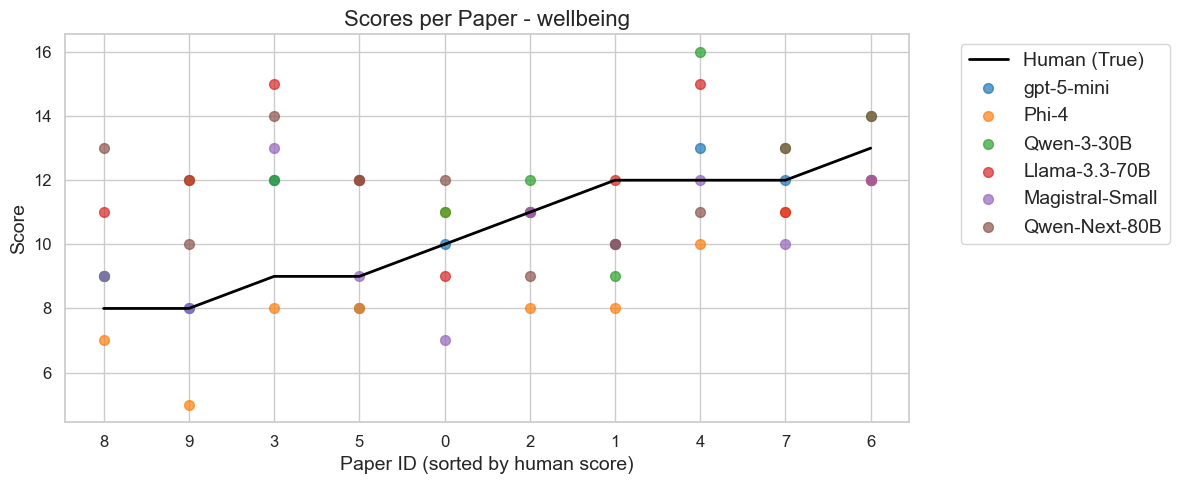

Best matching LLM (Spearman) for wellbeing: Phi-4 with correlations {'gpt-5-mini': np.float64(0.7044025157232705), 'Phi-4': np.float64(0.8052145660798129), 'Qwen-3-30B': np.float64(0.5176379353370225), 'Llama-3.3-70B': np.float64(0.10036620577691731), 'Magistral-Small': np.float64(0.5109257403949736), 'Qwen-Next-80B': np.float64(0.06875134281277785)}
Best matching LLM (MAE) for wellbeing: gpt-5-mini with correlations {'gpt-5-mini': np.float64(0.9), 'Phi-4': np.float64(1.8), 'Qwen-3-30B': np.float64(2.2), 'Llama-3.3-70B': np.float64(2.2), 'Magistral-Small': np.float64(1.3), 'Qwen-Next-80B': np.float64(2.4)}
Best matching LLM (RMSE) for wellbeing: gpt-5-mini with correlations {'gpt-5-mini': np.float64(1.3038404810405297), 'Phi-4': np.float64(2.0976176963403033), 'Qwen-3-30B': np.float64(2.5298221281347035), 'Llama-3.3-70B': np.float64(2.8635642126552705), 'Magistral-Small': np.float64(1.8708286933869707), 'Qwen-Next-80B': np.float64(2.792848008753788)}


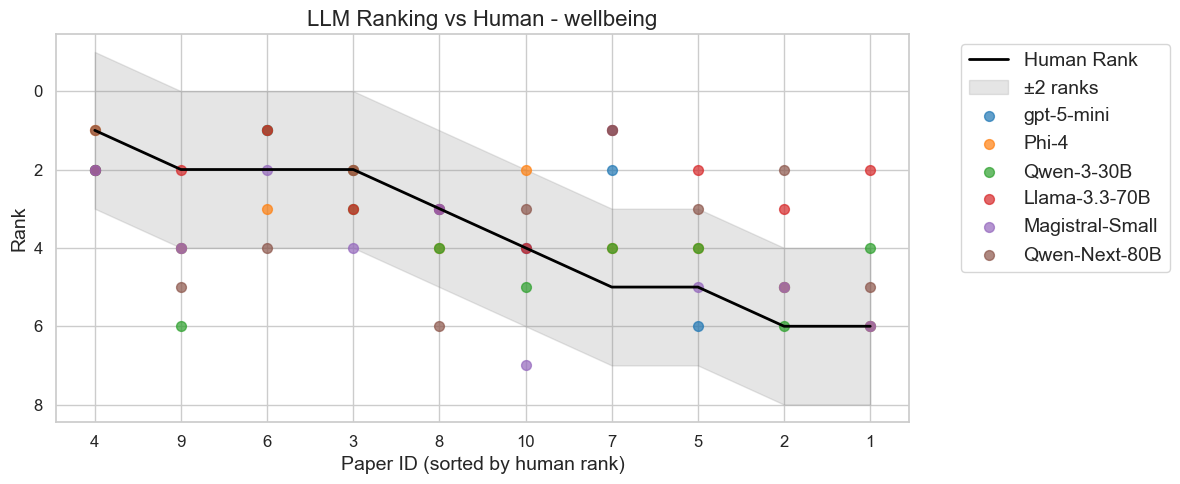

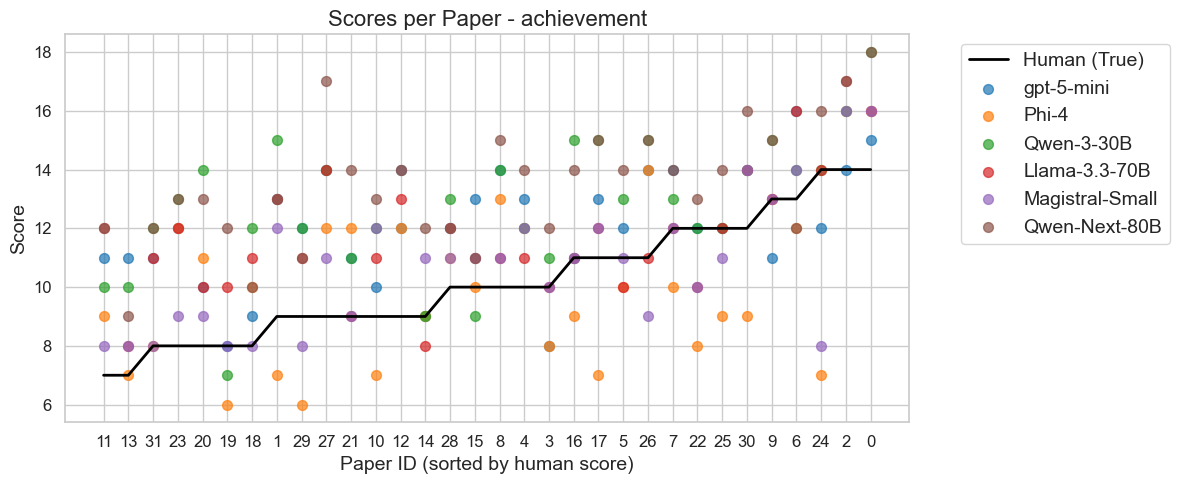

Best matching LLM (Spearman) for achievement: Qwen-Next-80B with correlations {'gpt-5-mini': np.float64(0.5797849252323032), 'Phi-4': np.float64(0.3079379363456382), 'Qwen-3-30B': np.float64(0.5636462193639339), 'Llama-3.3-70B': np.float64(0.5088255744191315), 'Magistral-Small': np.float64(0.6070363092645056), 'Qwen-Next-80B': np.float64(0.6322231760532125)}
Best matching LLM (MAE) for achievement: Magistral-Small with correlations {'gpt-5-mini': np.float64(2.125), 'Phi-4': np.float64(2.21875), 'Qwen-3-30B': np.float64(2.71875), 'Llama-3.3-70B': np.float64(1.78125), 'Magistral-Small': np.float64(1.375), 'Qwen-Next-80B': np.float64(3.34375)}
Best matching LLM (RMSE) for achievement: Magistral-Small with correlations {'gpt-5-mini': np.float64(2.5495097567963922), 'Phi-4': np.float64(2.6516504294495533), 'Qwen-3-30B': np.float64(3.225871975140985), 'Llama-3.3-70B': np.float64(2.3251344047172844), 'Magistral-Small': np.float64(1.9525624189766635), 'Qwen-Next-80B': np.float64(3.678484742390

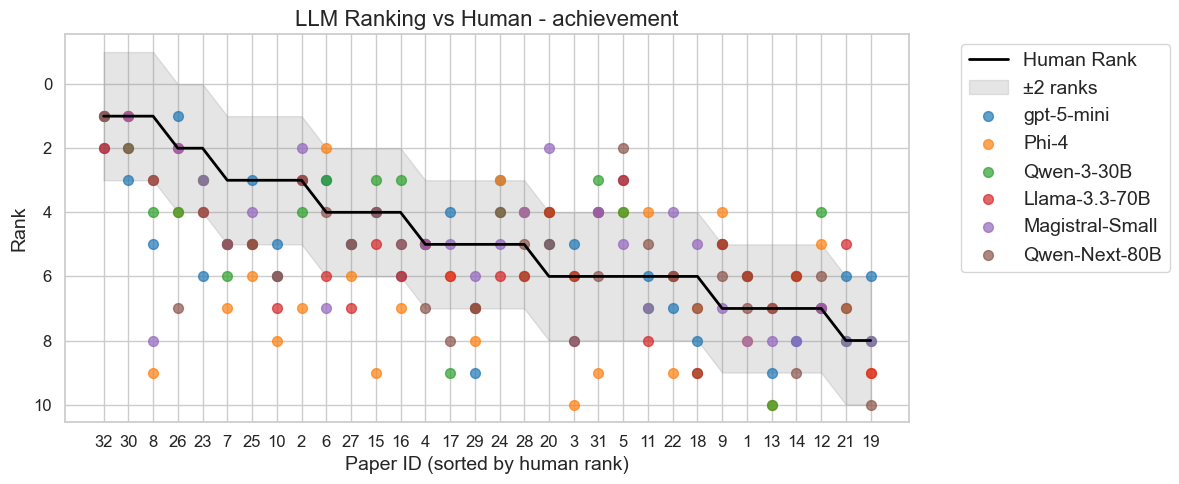

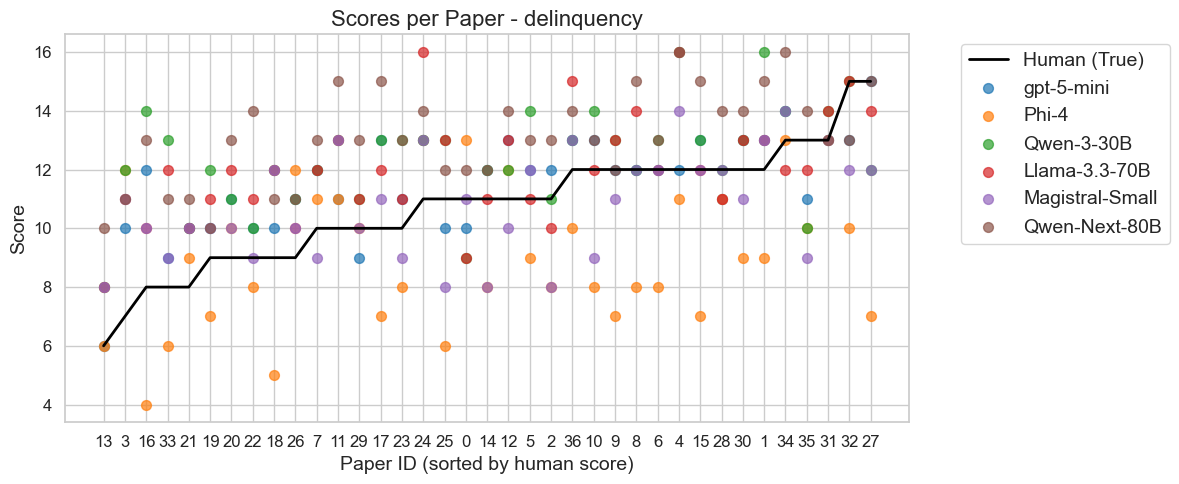

Best matching LLM (Spearman) for delinquency: gpt-5-mini with correlations {'gpt-5-mini': np.float64(0.7144069066001387), 'Phi-4': np.float64(0.2469115048236711), 'Qwen-3-30B': np.float64(0.4422351780359194), 'Llama-3.3-70B': np.float64(0.6216425689989231), 'Magistral-Small': np.float64(0.49169693848913426), 'Qwen-Next-80B': np.float64(0.5948765291804627)}
Best matching LLM (MAE) for delinquency: gpt-5-mini with correlations {'gpt-5-mini': np.float64(1.2162162162162162), 'Phi-4': np.float64(2.5945945945945947), 'Qwen-3-30B': np.float64(2.081081081081081), 'Llama-3.3-70B': np.float64(1.7027027027027026), 'Magistral-Small': np.float64(1.5135135135135136), 'Qwen-Next-80B': np.float64(2.4864864864864864)}
Best matching LLM (RMSE) for delinquency: gpt-5-mini with correlations {'gpt-5-mini': np.float64(1.5156837721956706), 'Phi-4': np.float64(3.1537193828788803), 'Qwen-3-30B': np.float64(2.5308902396993447), 'Llama-3.3-70B': np.float64(2.1117432276343306), 'Magistral-Small': np.float64(1.931

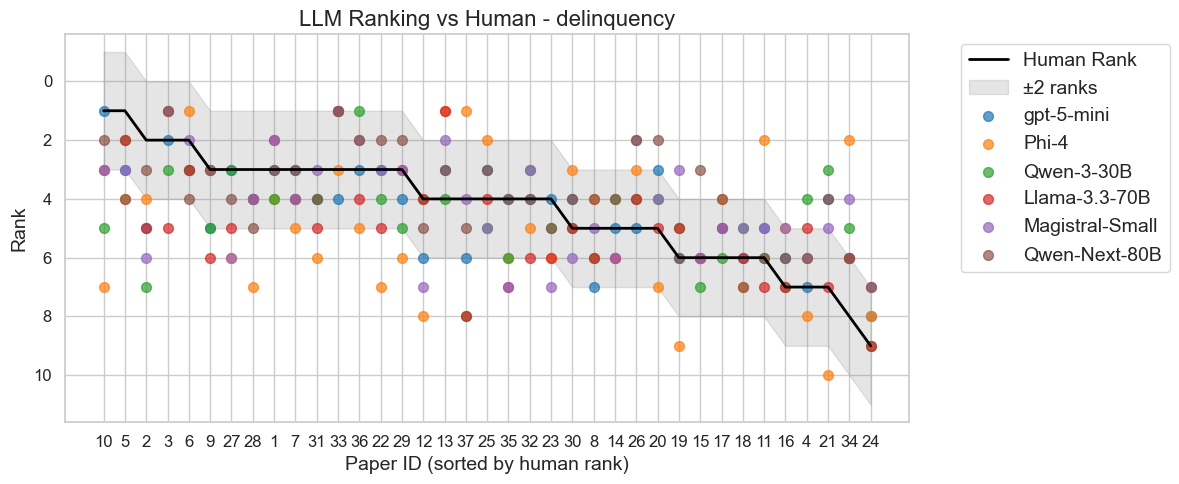

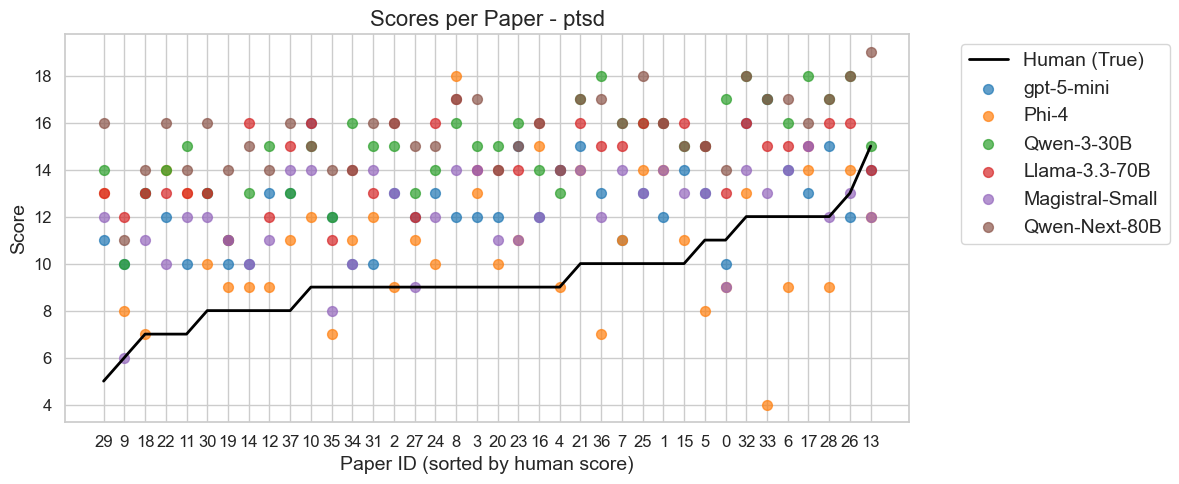

Best matching LLM (Spearman) for ptsd: Qwen-3-30B with correlations {'gpt-5-mini': np.float64(0.4652457942300284), 'Phi-4': np.float64(0.08241300210142723), 'Qwen-3-30B': np.float64(0.7583507767546515), 'Llama-3.3-70B': np.float64(0.4972407745749196), 'Magistral-Small': np.float64(0.43177327354447115), 'Qwen-Next-80B': np.float64(0.5828045033617982)}
Best matching LLM (MAE) for ptsd: Phi-4 with correlations {'gpt-5-mini': np.float64(3.3421052631578947), 'Phi-4': np.float64(2.8684210526315788), 'Qwen-3-30B': np.float64(5.526315789473684), 'Llama-3.3-70B': np.float64(5.0), 'Magistral-Small': np.float64(2.973684210526316), 'Qwen-Next-80B': np.float64(6.184210526315789)}
Best matching LLM (RMSE) for ptsd: Magistral-Small with correlations {'gpt-5-mini': np.float64(3.731092686007538), 'Phi-4': np.float64(3.6526846651686067), 'Qwen-3-30B': np.float64(5.753717333854239), 'Llama-3.3-70B': np.float64(5.301439725008174), 'Magistral-Small': np.float64(3.4297460393937103), 'Qwen-Next-80B': np.floa

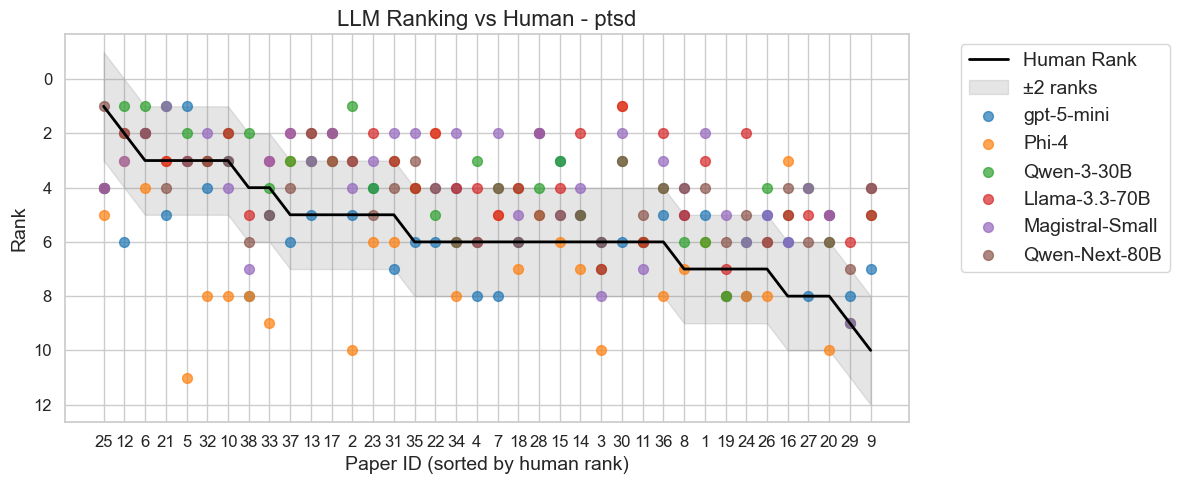

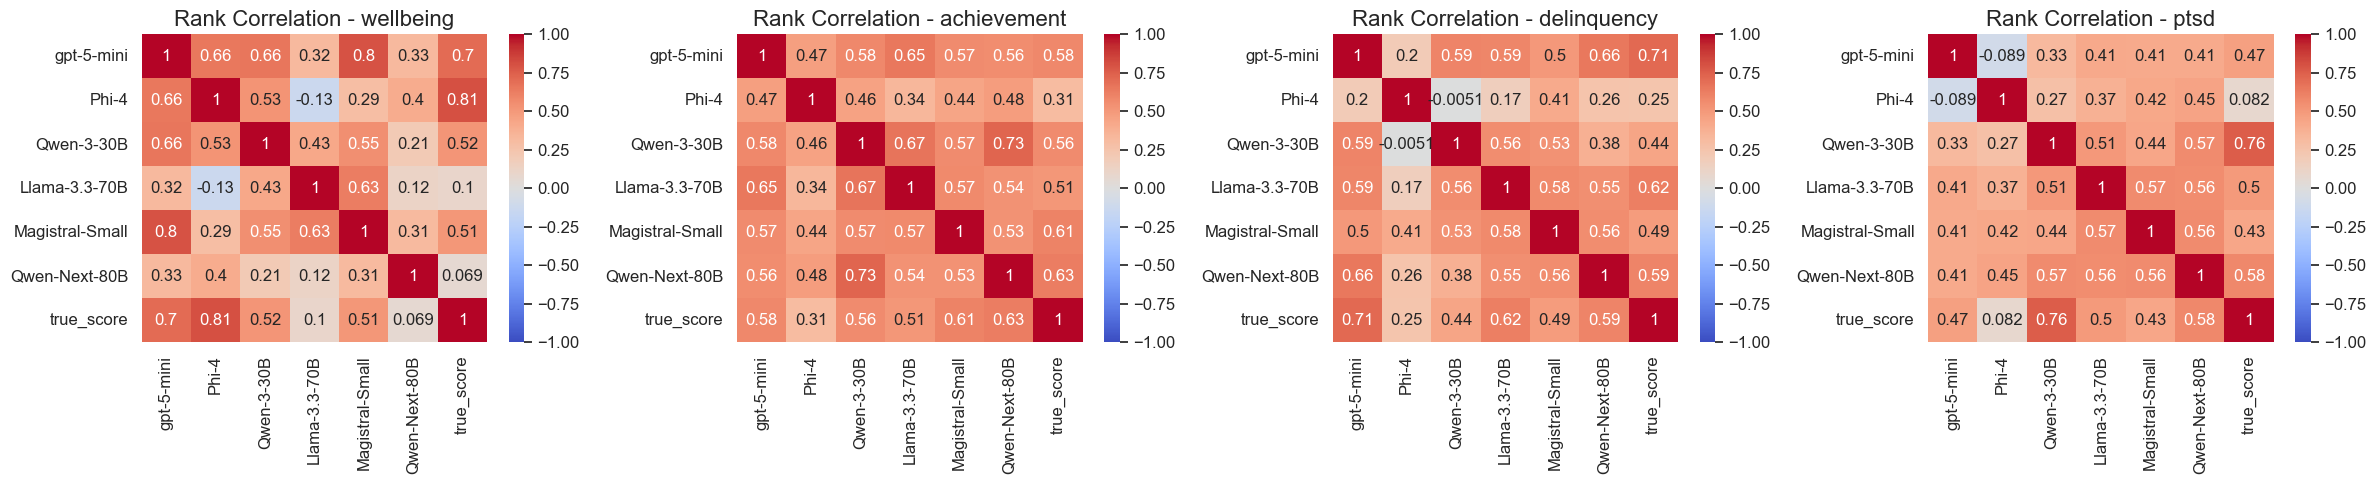

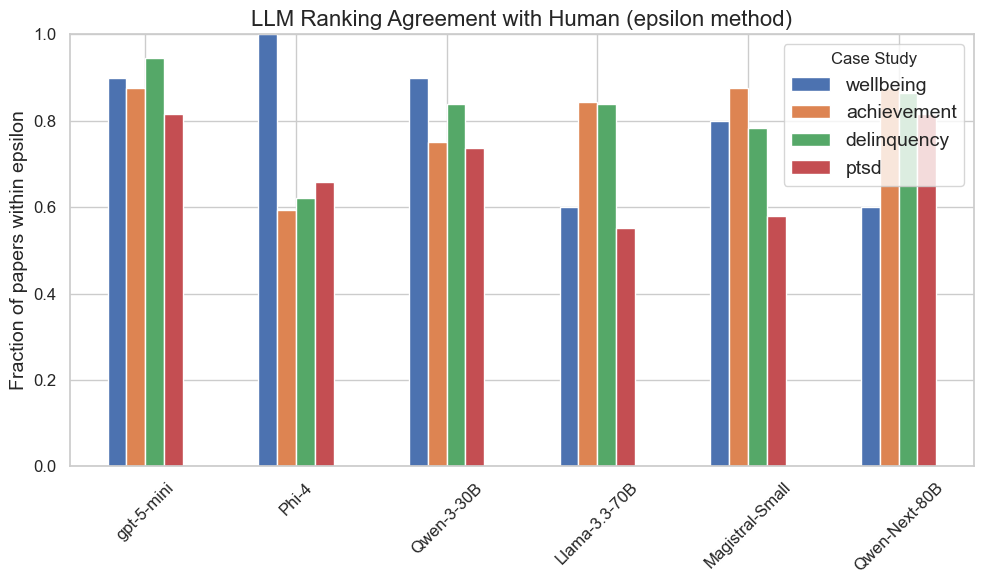

In [3]:
scores_dfs = []
rank_dfs = []
rank_diffs = []
rank_agreements = []
# Load labels
for subfolder in SUBFOLDERS:
    df_labels = pd.read_csv(f"./human_labels/{subfolder}.csv", delimiter=";", dtype=int)
    df_labels = df_labels.melt(
        id_vars=["paper_id"], var_name="question_id", value_name="answer"
    )
    df_labels["paper_id"] = df_labels["paper_id"].astype(int)
    df_labels["question_id"] = df_labels["question_id"].astype(int)
    df_labels["answer"] = df_labels["answer"].astype(int)

    files = [
        f"Qwen_Qwen3-Embedding-8B_gpt-5-mini_{subfolder}_500_{'0' if subfolder == 'ptsd' else '4'}.csv",
        f"Qwen_Qwen3-Embedding-8B_microsoft_phi-4_{subfolder}_500_{'0' if subfolder == 'ptsd' else '4'}.csv",
        f"Qwen_Qwen3-Embedding-8B_Qwen_Qwen3-30B-A3B-Instruct-2507_{subfolder}_500_{'0' if subfolder == 'ptsd' else '4'}.csv",
        f"Qwen_Qwen3-Embedding-8B_meta-llama_Llama-3.3-70B-Instruct_{subfolder}_500_{'0' if subfolder == 'ptsd' else '4'}.csv",
        f"Qwen_Qwen3-Embedding-8B_mistralai_Magistral-Small-2509_{subfolder}_500_{'0' if subfolder == 'ptsd' else '4'}.csv",
        f"Qwen_Qwen3-Embedding-8B_Qwen_Qwen3-Next-80B-A3B-Instruct_{subfolder}_500_{'0' if subfolder == 'ptsd' else '4'}.csv",
    ]

    scores_df, rank_df, rank_diff = load_llm_scores(df_labels, files)
    # plot_accuracy_with_human(acc_df, subfolder)
    scores_dfs.append(scores_df)
    rank_dfs.append(rank_df)
    rank_diffs.append(rank_diff)
    plot_scores_by_paper(scores_df, subfolder)
    best_llm_sp, correlations = best_matching_llm_rank(scores_df)
    print(
        f"Best matching LLM (Spearman) for {subfolder}: {best_llm_sp} with correlations {correlations}"
    )
    best_llm_mae, maes = best_matching_llm_mae(scores_df)
    print(
        f"Best matching LLM (MAE) for {subfolder}: {best_llm_mae} with correlations {maes}"
    )
    best_llm_rmse, rmses = best_matching_llm_rmse(scores_df)
    print(
        f"Best matching LLM (RMSE) for {subfolder}: {best_llm_rmse} with correlations {rmses}"
    )

    rank_agreements.append(ranking_agreement(rank_df, epsilon=2))
    plot_ranking_scatter_with_epsilon(rank_df, subfolder, epsilon=2)


plot_rank_correlation(rank_dfs, SUBFOLDERS)
plot_ranking_agreement(rank_agreements, SUBFOLDERS)